# Library Used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
from sklearn.utils import shuffle # shuffling for Experiment 3
from sklearn import metrics # creating confusion matrix

# Read Data

In [30]:
train = pd.read_csv("mnist_train.csv")
test = pd.read_csv("mnist_test.csv")

# Convert datasets from pandas *dataframe* to numpy *array*

In [31]:
train = train.to_numpy() 
test = test.to_numpy()

# Shuffling and randomly pick a specific amounts of data for Experiment #3

In [29]:
shuffled_train = shuffle(train)

class_count = np.array([0 for k in range(10)])

train_50 = []
for i in range(len(shuffled_train)):
    if len(train_50) == 30000:
        break 
    if class_count[shuffled_train[i,0]] <= 3000:
        class_count[shuffled_train[i,0]] += 1
        train_50.append(shuffled_train[i,:])

train = np.array(train_50)

# Seperate the label columns and make bias columns
In other words, separate the train x and the label column (train y, named train_label in the assignment) and updated the train x by creating a bias column(bias is 1). Same process for the test data as well.

In [32]:
train_label = np.array([train[i,0] for i in range (train.shape[0])]) 
test_label = np.array([test[i,0] for i in range (test.shape[0])])

test_1d = test_label # test 1d will be used for creating the confusion matrix

# change the first column as the bias column (1). Even though name is still label, now it's bias column
train[:, 0] = 1 
test[:, 0] = 1

# Change the label column 
Each output unit corresponds to one of the 10 classes ('0' to '9'). Set the target value $t_k$ for output unit $k$ to 0.9 if the input class is the $k$ th class, 0.1 otherwise.

In [33]:
def change_target_value(x):
  t = []

  for i in range(len(x)):
    target = np.array([0.1 for i in range(10)])
    for j in range(10):
      if (j == x[i]):
        target[j] = 0.9
        break
    t.append(target) 

  t = np.array(t)
  return t

In [34]:
train_target = change_target_value(train_label)
test_target = change_target_value(test_label)

# Preprocessing
Scale the data values to be between 0 and 1 by dividing by 255

In [35]:
train = np.divide(train, 255) 
test = np.divide(test, 255) 

# Initialize parameters

In [36]:
n = 20 # hidden units

alpha = 0.9 # momentum

# choose random weights from input to h 
w1 = np.random.uniform(low=-0.05, high=0.05, size=(n,785)) 
w2 = np.random.uniform(low=-0.05, high=0.05, size=(10,n+1))

w1_T = np.transpose(w1)
w2_T = np.transpose(w2)

# the previous weights to update weights
previous_weight1 = np.zeros((785, n))
previous_weight2 = np.zeros((n+1, 10))

eda =  0.1 # learning rate 
epochs = 50
train_accurate = 0 # count to calculate accuracy
test_accurate = 0
accuracy_train = 0.0 
accuracy_test = 0.0
train_accuracy_array = [] 
test_accuracy_array = [] 

# Network Classification (Forward Propagation)
1. $h = W_1 @ x$
  - compute the activation $h_j$ of each hidden unit $j$
2. $y = W_2 @ h$
  - compute the activation $y_k$ of each output unit $k$

# Network Training (Back Propagation)
1. Errors
  - for each output unit $k$, calculate error term $δ_k$
    - $\delta_k ← y_k(1-y_k)(t_k-y_k)$

  - for each hidden unit $j$, calculate error term $\delta_j$
    - $\delta_j \leftarrow h_j(1-h_j)(∑\limits_{kϵoutput units}{} W_{kj}\delta_k)$
2. Update Weights
  - Hidden to Output layer ($W2$)
    - $w_{kj} ← w_{kj} - Δw_{kj}$
      where $Δw_{kj}$ = ηδ_{k}h_{j} + α $Δw_{kj}^{t-1}$)
  - Input to Hidden layer ($W1$)
    - $w_{ji} ← w_{ji} - Δw_{ji}$ where $Δw_{ji}$ = ηδ_{j}x_{i} + α $Δw_{ji}^{t-1}$)

In [37]:
# sigmoid function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [38]:
for epoch in range(epochs):

    for i in range(0, train.shape[0]):
        h = w1 @ train[i,:] # get the hidden unit

        # use the sigmoid fn for the activation
        h = sigmoid(h)

        # append 1 for bias -> now h is (n+1) x 1
        h = np.append(h, [1], axis = 0) 

        h = h.reshape(n+1, 1)

        y = w2 @ h # get the output unit
        
        # use the sigmoid fn for the activation
        y = sigmoid(y)
        y = y.reshape(10,1)

        # calculate error terms for output unit
        i_o = np.ones((y.shape[0], 1)) # the column vector with 1s for the output unit
        del_y = y * (i_o - y) * (train_target[i,:].reshape(10,1) - y)  

        # calculate error terms for hidden unit
        i_h = np.ones((h.shape[0], 1)) # the column vector with 1s for the hidden unit
        del_j = h * (i_h - h) * (w2.T @ del_y) # (n+1) x 1

        # note that the last element is 1 - bias, and our bias is one, so 1-bias (1-1) should be zero. 
        # thus we can remove that zero cuz we want to get n x 1 matrix instead of n+1 x 1 matrix
        del_j = np.delete(del_j, (len(del_j)-1)) # now delta j (error term j) is n x 1

        # update weight w2 (hidden to output edges)
        change_weight2 = (eda * h * del_y.T) + (alpha * previous_weight2) 
        previous_weight2 = np.copy(change_weight2)
        w2_T += change_weight2 ###################################### - or +?

        # update weight w1 (input to hidden edges)
        change_weight1 = (eda * train[i,:].reshape(train.shape[1], 1) * del_j) + (alpha * previous_weight1)
        previous_weight1 = np.copy(change_weight1)
        w1_T += change_weight1


    for i in range(0, train.shape[0]):
        h = w1 @ train[i,:] # get the hidden unit

        # use the sigmoid fn for the activation
        h = sigmoid(h)

        # append 1 for bias -> now h is (n+1) x 1
        h = np.append(h, [1], axis = 0) 

        h = h.reshape(n+1, 1)

        y = w2 @ h # get the output unit
        
        # use the sigmoid fn for the activation
        y = sigmoid(y)
        y = y.reshape(10,1)
        
        if np.argmax(y) == np.argmax(train_target[i]):
            train_accurate += 1
            
    if epoch == epochs-1:
        pred = np.array([0 for k in range(len(test))]) # store the predictions

    for i in range(0, test.shape[0]):
        h = w1 @ test[i,:] # get the hidden unit

        # use the sigmoid fn for the activation
        h = sigmoid(h)

        # append 1 for bias -> now h is (n+1) x 1
        h = np.append(h, [1], axis = 0) 

        h = h.reshape(n+1, 1)

        y = w2 @ h # get the output unit
        
        # use the sigmoid fn for the activation
        y = sigmoid(y)
        y = y.reshape(10,1)
        
        # store the value to pred for confusion matrix
        if epoch == epochs-1:
            pred[i] = np.argmax(y)

        if np.argmax(y) == np.argmax(test_target[i]):
            test_accurate += 1
        
                    
    
    accuracy_train = train_accurate / train.shape[0]
    accuracy_test = test_accurate / test.shape[0]
    train_accuracy_array.append(100 * accuracy_train) 
    test_accuracy_array.append(100 * accuracy_test)

    train_accurate = 0 # for next iteration
    test_accurate = 0

# Create confusion matrix

In [39]:
confusion_matrix = metrics.confusion_matrix(test_1d, pred)
print(confusion_matrix)

[[ 950    0    7    2    1    2    7    1    6    4]
 [   0 1109    3    4    1    1    5    0    7    5]
 [   2    1  962   11    6    2   10    6   22   10]
 [   3    0   24  937    0   14    3    5   11   13]
 [   0    1    4    1  912    0   11    0    4   49]
 [   2    2    8   36    2  800   11    6   15   10]
 [   7    5   13    1    3   15  905    0    6    3]
 [   0    5   22    2    4    1    0  964    9   21]
 [   5    1    8   14    8   23   10    4  882   19]
 [   4    5    2   10   18    6    0   10    9  945]]


# Plot train and test accuracies

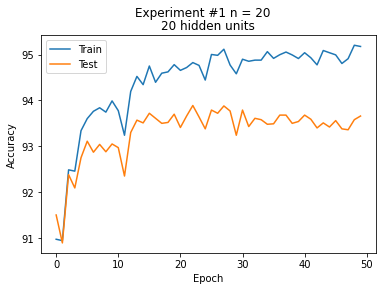

In [41]:
plt.suptitle("Experiment #1 n = 20" )
plt.title("20 hidden units")
plt.plot(train_accuracy_array, label = 'Train')
plt.plot(test_accuracy_array, label = 'Test')
plt.ylabel('Accuracy', fontsize = 10)
plt.xlabel('Epoch', fontsize=10)
plt.legend()
plt.show()